In [1]:
import numpy as np
import sys

sys.path.append('/global/homes/w/wenhan/source/pyvisos')
sys.path.append('/global/homes/w/wenhan/source/plasma_theory')
from osh5io import *
from osh5vis import *
from osh5visipy import *
from osh5utils import *
from plasma_dispersion import *
from lpi_theory import *
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve
from scipy import signal
from functools import partial
import glob

Importing osh5visipy. Please use `%matplotlib notebook' in your jupyter/ipython notebook


## physical parameters

In [13]:
TkeV = 3. # temperature in keV
n0 = np.linspace(0.01, 0.25, 500) # lowest and highest densities, and how many denisty points in total
I14 = 5
ln = 1000 # micron, at rescattering densities, used in growth rate calculation
locr = 0.5 # local reflectivity, used in growth rate calculation

## solve dispersion for SRBS and its Raman rescattering (SRBS of SRBS)

In [14]:
vth = np.sqrt(TkeV/511.)

wepw = get_backward_srs_w(n0, vth, kinetic=False)
kepw = backward_srs_k_epw(wepw, n0)
w1 = np.array([1.-wi if wi is not None else None for wi in wepw])
k1 = np.array([ki-np.sqrt(1.-ni) if ki is not None else None for ni, ki in zip(n0, kepw)])
wepw_kin = get_backward_srs_w(n0, vth, kinetic=True)
kepw_kin = backward_srs_k_epw(np.real(wepw_kin), n0)
w1_kin = np.array([1.-wi if wi is not None else None for wi in np.real(wepw_kin)])
k1_kin = np.array([ki-np.sqrt(1.-ni) if ki is not None else None for ni, ki in zip(n0, np.real(kepw_kin))])
vph = np.array([wi/ki if wi is not None and ki is not None else None for wi,ki in zip(wepw, kepw)])
vph_kin = np.array([wi/ki if wi is not None and ki is not None else None for wi,ki in zip(np.real(wepw_kin), np.real(kepw_kin))])

rwepw_kin, rkepw_kin, rw1_kin, rk1_kin, rwepw, rkepw, rw1, rk1, rvph, rvph_kin, notdefine = [], [], [], [], [], [], [], [], [], [], np.array([0,]*np.size(n0))
rtpdkp, rtpdgr = [], []
for i, w in enumerate(wepw_kin):
    if w is None:
        rwepw_kin.append(notdefine)
        rkepw_kin.append(notdefine)
        rk1_kin.append(notdefine)
        rw1_kin.append(notdefine)
        continue
    rn0 = n0 / (1. - np.real(w))**2
    rw = get_backward_srs_w(rn0, vth, kinetic=True)
    rw[i:] = None
    rk = backward_srs_k_epw(np.real(rw), rn0)
    rvph_kin.append(np.array([wi/ki if wi is not None and ki is not None else 0 for wi,ki in zip(rw,rk)]))
    rk1_kin.append(np.array([(1.-np.real(w))*(ki-np.sqrt(1-rn0i)) if ki is not None else 0 for ki,rn0i in zip(rk, rn0)]))
    rw1_kin.append([(1.-rwi)*(1.-np.real(w)) if rwi is not None else 0 for rwi in rw])
    rw = np.array([np.real(rwi*(1. - np.real(w))) if rwi is not None else 0 for rwi in rw])
    rwepw_kin.append(rw)
    rkepw_kin.append(np.array([rki*(1. - np.real(w)) if rki is not None else 0 for rki in rk]))
    
for i, w in enumerate(wepw):
    if w is None:
        rwepw.append(notdefine)
        rkepw.append(notdefine)
        rk1.append(notdefine)
        rw1.append(notdefine)
        continue
    rn0 = n0 / (1. - np.real(w))**2
    rw = get_backward_srs_w(rn0, vth, kinetic=False)
    rw[i:] = None
    rk = backward_srs_k_epw(np.real(rw), rn0)
    rvph.append(np.array([wi/ki if wi is not None and ki is not None else 0 for wi,ki in zip(rw,rk)]))
    rk1.append(np.array([(1.-np.real(w))*(ki-np.sqrt(1-rn0i)) if ki is not None else 0 for ki,rn0i in zip(rk, rn0)]))
    rw1.append(np.array([(1.-rwi)*(1.-np.real(w)) if rwi is not None else 0 for rwi in rw]))
    rw = np.array([rwi*(1. - np.real(w)) if (rwi is not None) and (1.-rwi>np.sqrt(n)) else 0 for rwi,n in zip(rw, rn0)])
    rwepw.append(rw)
    rkepw.append(np.array([rki*(1. - np.real(w)) if rki is not None else 0 for rki in rk]))

## plot the dispersion of SRBS and SRBS of SRBS

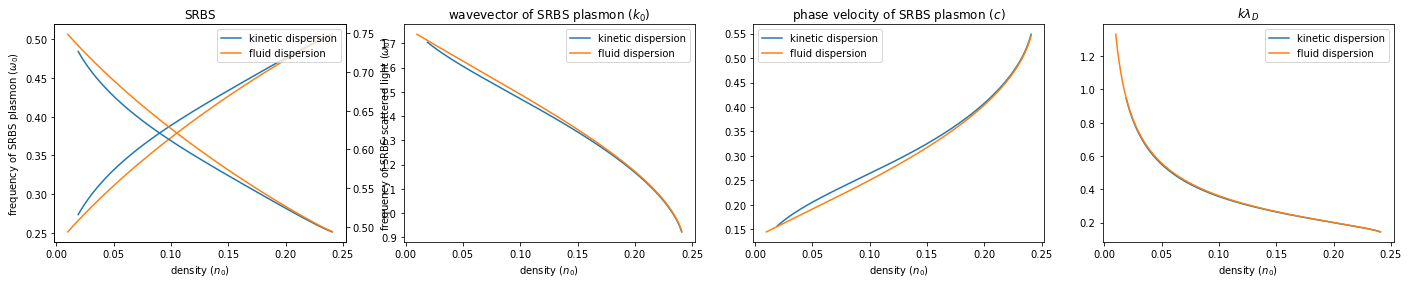

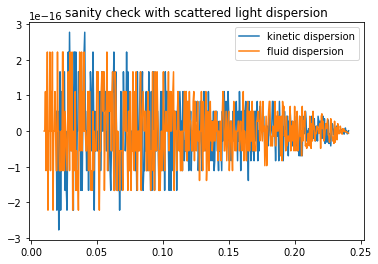

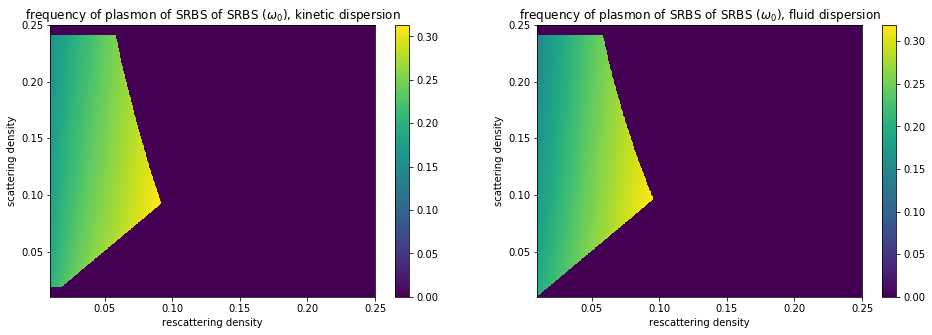

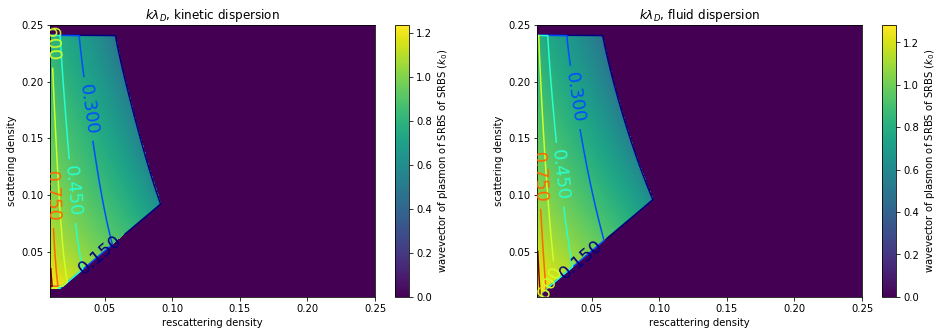

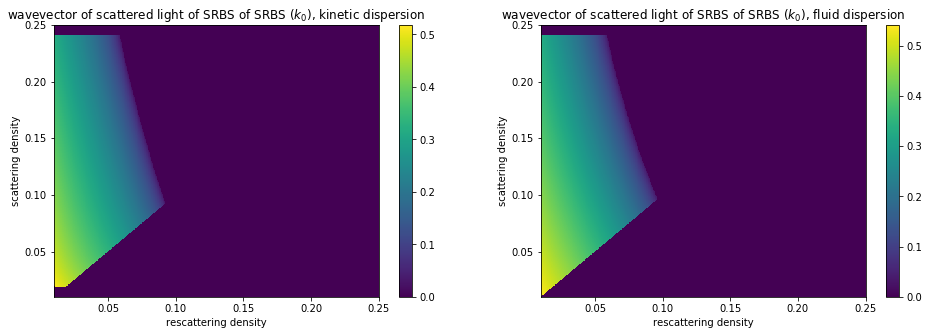

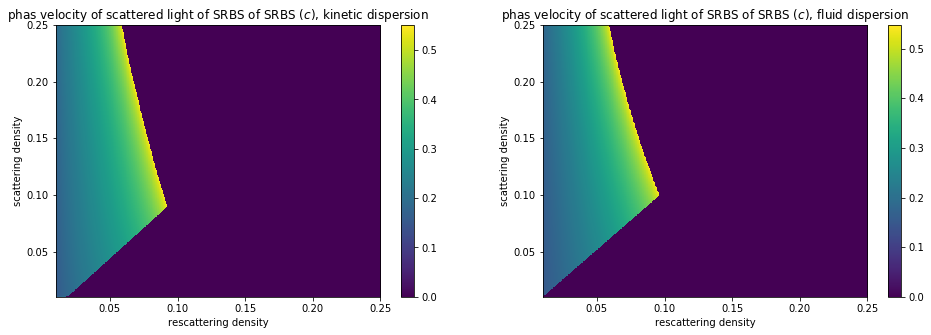

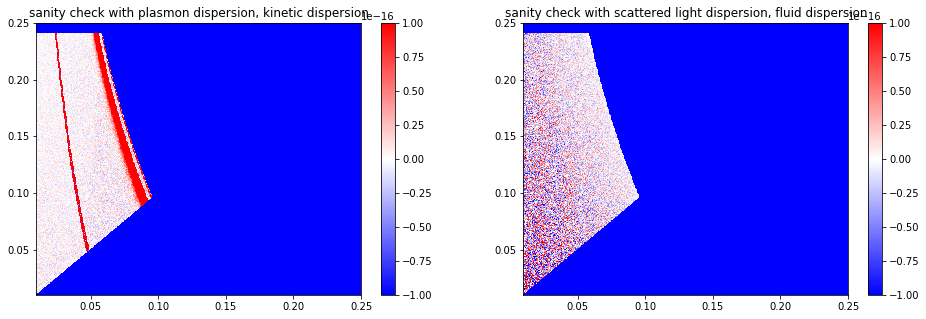

In [15]:
plt.figure(figsize=[24, 4])
fig1 = plt.subplot(141)
plt.plot(n0, np.real(wepw_kin))
plt.plot(n0, wepw)
plt.xlabel('density ($n_0$)')
plt.ylabel('frequency of SRBS plasmon ($\omega_0$)')
plt.title('SRBS')
ax2 = fig1.axes.twinx()
ax2.plot(n0, np.real(w1_kin))
ax2.plot(n0, w1)
plt.ylabel('frequency of SRBS scattered light ($\omega_0$)')
plt.legend(['kinetic dispersion', 'fluid dispersion'])

plt.subplot(142)
plt.plot(n0, np.real(kepw_kin))
plt.plot(n0, kepw)
plt.xlabel('density ($n_0$)')
plt.title('wavevector of SRBS plasmon ($k_0$)')
plt.legend(['kinetic dispersion', 'fluid dispersion'])

plt.subplot(143)
plt.plot(n0, vph_kin)
plt.plot(n0, vph)
plt.xlabel('density ($n_0$)')
plt.title('phase velocity of SRBS plasmon ($c$)')
plt.legend(['kinetic dispersion', 'fluid dispersion'])

plt.subplot(144)
plt.plot(n0, [k*vth/np.sqrt(n) if k is not None else None for k,n in zip(kepw_kin, n0)])
plt.plot(n0, [k*vth/np.sqrt(n) if k is not None else None for k,n in zip(kepw, n0)])
plt.xlabel('density ($n_0$)')
plt.title('$k \lambda_D$')
plt.legend(['kinetic dispersion', 'fluid dispersion'])

plt.figure()
plt.plot(n0, [w**2-n-k**2 if w is not None else None for w,n,k in zip(np.real(w1_kin), n0, np.real(k1_kin))])
plt.plot(n0, [w**2-n-k**2 if w is not None else None for w,n,k in zip(np.real(w1), n0, k1)])
plt.title('sanity check with scattered light dispersion')
plt.legend(['kinetic dispersion', 'fluid dispersion'])

plt.figure(figsize=[16, 5])
plt.subplot(121)
plt.imshow(np.real(rwepw_kin), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('frequency of plasmon of SRBS of SRBS ($\omega_0$), kinetic dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')
plt.subplot(122)
plt.imshow(np.real(rwepw), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('frequency of plasmon of SRBS of SRBS ($\omega_0$), fluid dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')


plt.figure(figsize=[16, 5])
plt.subplot(121)
plt.imshow(np.real(rkepw_kin), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar(label='wavevector of plasmon of SRBS of SRBS ($k_0$)')
CS = plt.contour(np.real(rkepw_kin)*vth/np.sqrt(n0), origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]), cmap='jet'); plt.clabel(CS, inline=1, fontsize=18)
plt.title('$k\lambda_D$, kinetic dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')
plt.subplot(122)
plt.imshow(np.real(rkepw), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar(label='wavevector of plasmon of SRBS of SRBS ($k_0$)')
CS = plt.contour(np.real(rkepw)*vth/np.sqrt(n0), origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]), cmap='jet'); plt.clabel(CS, inline=1, fontsize=18)
plt.title('$k\lambda_D$, fluid dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')


plt.figure(figsize=[16, 5])
plt.subplot(121)
plt.imshow(np.real(rk1_kin), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('wavevector of scattered light of SRBS of SRBS ($k_0$), kinetic dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')
plt.subplot(122)
plt.imshow(np.real(rk1), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('wavevector of scattered light of SRBS of SRBS ($k_0$), fluid dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')

plt.figure(figsize=[16, 5])
plt.subplot(121)
plt.imshow(np.real(rvph_kin), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('phas velocity of scattered light of SRBS of SRBS ($c$), kinetic dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')
plt.subplot(122)
plt.imshow(np.real(rvph), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('phas velocity of scattered light of SRBS of SRBS ($c$), fluid dispersion')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')


plt.figure(figsize=[16, 5])
plt.subplot(121)
d = np.stack([rw**2-n0-3*vth*vth*rk**2 for rw,rk in zip(rwepw,rkepw)])
plt.imshow(d, aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]), cmap='bwr')
plt.clim([-1e-16,1e-16])
plt.title('sanity check with plasmon dispersion, kinetic dispersion')
plt.colorbar()
plt.subplot(122)
d = np.stack([rw**2-n0-rk**2 for rw,rk in zip(rw1,rk1)])
plt.imshow(d, aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]), cmap='bwr')
plt.clim([-1e-16,1e-16])
plt.title('sanity check with scattered light dispersion, fluid dispersion')
plt.colorbar()


## dispersion and growth rate of rescattering (TPD of SRBS)

In [11]:
rkptpd, rklarge, rgrtpd, rgrtpd_zoom, nz_l, nz_h, res = [], [], [], [], n0[0], 0.12, 1000
for i, w in enumerate(wepw_kin):
    if w is None:
        rgrtpd_zoom.append([0] * res)
        rkptpd.append(notdefine)
        rgrtpd.append(notdefine)
        rklarge.append(notdefine)
        continue
    
    fac = (1. - np.real(w))
    rn0 = n0 / fac**2
    kp = np.array([tpd_k_perp(ni, vth) for ni in rn0])
    kp[i:] = None
    rkptpd.append(np.array([k*fac if k is not None else 0 for k in kp]))
    rklarge.append(np.array([tpd_large_k(k, n)*fac if k is not None else 0 for k, n in zip(kp, rn0)]))
    
    rgrtpd.append( tpd_growth_rate(locr*I14, rn0, vth, ln*fac, kp=kp, wavelength=0.351/fac) * fac )
    
    rn0 = np.linspace(nz_l, nz_h, res) / fac**2
    kp = np.array([tpd_k_perp(ni, vth) for ni in rn0])
    idx = rn0 > n0[i] / fac**2
    kp[idx] = None
    rgrtpd_zoom.append( tpd_growth_rate(locr*I14, rn0, vth, ln*fac, kp=kp, wavelength=0.351/fac) * fac )

Text(0.5,0,'rescattering density')

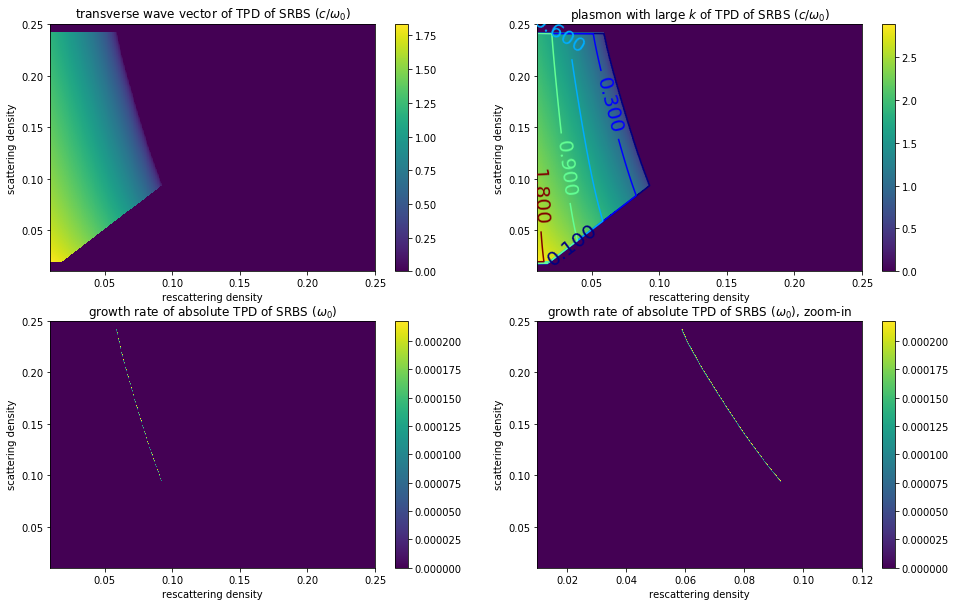

In [10]:
plt.figure(figsize=[16, 10])
plt.subplot(221)
plt.imshow(np.real(rkptpd), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('transverse wave vector of TPD of SRBS ($c/\omega_0$)')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')
plt.subplot(222)
plt.imshow(np.real(rklarge), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
levels = np.array([0.1, 0.3, 0.6, 0.9, 1.8])
CS = plt.contour(np.real(rklarge)*vth/np.sqrt(n0), levels, origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]), cmap='jet')
plt.clabel(CS, inline=1, fontsize=20)
plt.title('plasmon with large $k$ of TPD of SRBS ($c/\omega_0$)')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')
plt.subplot(223)
plt.imshow(np.real(rgrtpd), aspect='auto', origin='lower', extent=(n0[0],n0[-1], n0[0], n0[-1]))
plt.colorbar()
plt.title('growth rate of absolute TPD of SRBS ($\omega_0$)')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')
plt.subplot(224)
plt.imshow(np.real(rgrtpd_zoom), aspect='auto', origin='lower', extent=(nz_l, nz_h, n0[0], n0[-1]))
plt.colorbar()
plt.title('growth rate of absolute TPD of SRBS ($\omega_0$), zoom-in')
plt.ylabel('scattering density')
plt.xlabel('rescattering density')